# 逻辑回归预测贷款用户是否会逾期


我们提升算法实践能力的【整个思路】是这样的：构建模型——>模型融合——>模型评估——>交叉验证——>模型调参——>特征工程。【遵循】一次只做一件事，【先做再优化】的思路。每一个过程在完成任务的前提下，都可以拓展学习。【期望目标】掌握数据挖掘的流程，提升合作的能力。各位已经有经验，尤其是辅助的助教，还请多指导


给大家的是金融数据，我们要做的是预测贷款用户是否会逾期，表格中，status是标签：0表示未逾期，1表示逾期。【第一个任务】构建逻辑回归模型进行预测（在构建部分数据需要进行缺失值处理和数据类型转换，如果不能处理，可以直接暴力删除）【完成时间】11.14-11.15

# 1 环境准备 

## 1.1 导入所需的数据包

参考文档：
https://www.cnblogs.com/jin-liang/p/9011771.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score,r2_score
import seaborn as sns
# 去除 warnings 的警告
import warnings
warnings.filterwarnings('ignore')

# 设置显示窗口的大小
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

In [2]:
%%time
# 读取数据
PATH = "D:/SoftwareData/Database/jinrong"
# 问题1：dtype=object使用的问题
# train = pd.read_csv('{0}/data.csv'.format(PATH), encoding='gbk', dtype=object)  # 取消 dtype=object 的使用
train = pd.read_csv('{0}/data.csv'.format(PATH), encoding='gbk')

Wall time: 110 ms


# 2 特征工程

## 2.1 确认目前数据量和预测数据占比

In [3]:
# 确认数据量
train.shape

(4754, 90)

In [4]:
# 统计 逾期 和 没有逾期 的数据占比
# 0表示未逾期，1表示逾期 占比 3561: 1193
print(u"当前数据占比如下 {0} : ".format("*" * 20))
train.groupby(['status']).count()

当前数据占比如下 ******************** : 


,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3561,3561,3561,3561,3559,3559,3561,3558,3559,3559,3559,3554,3559,3559,1307,3561,3561,3559,3559,3561,3559,3559,3561,3559,3561,3559,3561,3481,3559,3554,3554,3554,3554,3242,3545,3545,3545,3540,3561,3554,3551,3561,3561,3551,3561,3559,3559,3352,3331,3331,3331,3331,3331,3331,3331,3331,3331,3331,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3336,3331,3336
1,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1192,1193,1193,449,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1193,1169,1193,1192,1192,1192,1192,1086,1193,1193,1193,1188,1193,1192,1191,1193,1193,1191,1193,1193,1193,1126,1119,1119,1119,1119,1119,1119,1119,1119,1119,1119,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1121,1119,1121


## 2.2 去掉一部分对结果没有影响的数据

从结果看，不难发现这五组数据对预测结果是没有影响的
- 只有一个值，没有区分度
    - bank_card_no:
    - source
- 与预测值无关，数据总共 4754，然后不相同的值4754个
    - trade_no
    - custid
    - Unnamed: 0

In [5]:
def unique_drop(data):
    """ 
    1. count 跟 unique 一样，需要删除
    2. count 跟 unique 不一样，只有单一值也是要删除
    3. count 跟 unique 不一样，但是 nan统计后，count 跟 unique 一样 也需要删除
    """
    for col in data.columns:
        count = len(list(data[col].unique()))
        if count == 1 or count == data.shape[0]:
            print(col)
            train.drop([col], inplace=True, axis=1)

unique_drop(train)

Unnamed: 0
custid
trade_no
bank_card_no
source


In [6]:
# 查看数据的类型
# train.info()

## 2.3 字符型特征

In [7]:
train_object = train.select_dtypes('object').copy()
train_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 4 columns):
reg_preference_for_trad    4752 non-null object
id_name                    4478 non-null object
latest_query_time          4450 non-null object
loans_latest_time          4457 non-null object
dtypes: object(4)
memory usage: 148.6+ KB


In [8]:
train_object.head(2)

,reg_preference_for_trad,id_name,latest_query_time,loans_latest_time
0,一线城市,蒋红,2018-04-25,2018-04-19
1,一线城市,崔向朝,2018-05-03,2018-05-05


In [9]:
train_object.describe()

,reg_preference_for_trad,id_name,latest_query_time,loans_latest_time
count,4752,4478,4450,4457
unique,5,4309,207,232
top,一线城市,张龙,2018-04-14,2018-05-03
freq,3403,5,423,134


In [10]:
def missing_count(train, feature):
    """
    1. 统计缺失值
    2. 统计unique
    """
    all_count = len(train)
    missing = len(train[feature][pd.isnull(train[feature])])
    unique_object = list(train[feature].unique())
    print("缺失{1:>4}个  缺失率 {4:.2f}% 有{2:>4}个值 分别为 {3}等".format(all_count, missing, len(unique_object),unique_object[:7], missing/all_count, feature))

In [11]:
missing_count(train_object,"reg_preference_for_trad")
missing_count(train_object,"id_name")

缺失   2个  缺失率 0.00% 有   6个值 分别为 ['一线城市', '三线城市', '境外', '二线城市', '其他城市', nan]等
缺失 276个  缺失率 0.06% 有4310个值 分别为 ['蒋红', '崔向朝', '王中云', '何洋洋', '赵洋', '刘成', '周雨浓']等


1. reg_preference_for_trad: 城市,使用0来填充 用 one-hot 编码
2. id_name：名字，理论上需要对相同名字的人进行归类, 这种做法先搁置了, 没想到更好的解决方法，先删除这一列数据
3. latest_query_time和loans_latest_time 当作时间特征来处理

In [12]:
train_object.describe()

,reg_preference_for_trad,id_name,latest_query_time,loans_latest_time
count,4752,4478,4450,4457
unique,5,4309,207,232
top,一线城市,张龙,2018-04-14,2018-05-03
freq,3403,5,423,134


In [13]:
# 缺失值2个，用众数填充
train_object['reg_preference_for_trad'] = train_object['reg_preference_for_trad'].fillna(train_object['reg_preference_for_trad'].mode()[0])
# 转换成数字
train_object['reg_preference_for_trad'] = train_object['reg_preference_for_trad'].map({'一线城市': 0, '二线城市': 1,'三线城市': 2,  '其他城市': 3, '境外': 4})
# one-hot编码
train_object = pd.get_dummies(train_object,columns=["reg_preference_for_trad"],prefix="reg_preference_for_trad")

In [14]:
# 删除id_name的字段
train_object.drop("id_name", inplace=True, axis=1)

In [15]:
train_object.head(2)

,latest_query_time,loans_latest_time,reg_preference_for_trad_0,reg_preference_for_trad_1,reg_preference_for_trad_2,reg_preference_for_trad_3,reg_preference_for_trad_4
0,2018-04-25,2018-04-19,1,0,0,0,0
1,2018-05-03,2018-05-05,1,0,0,0,0


## 2.4 日期/时间型特征
1. 取出日期，可分别构建如 年、月、日、工作日、周数 等；
2. 如有时间，可分别构建如 小时、分钟 等；
3. 两两日期或时间可根据业务知识相互做差，求出相差天数，小时数等

In [16]:
# 问题4：有没有更好的方法直接转换？
date_temp = pd.DataFrame()
date_temp['latest_query_time_year'] = pd.to_datetime(train_object['latest_query_time']).dt.year
date_temp['latest_query_time_month'] = pd.to_datetime(train_object['latest_query_time']).dt.month
date_temp['latest_query_time_day'] = pd.to_datetime(train_object['latest_query_time']).dt.day
date_temp['loans_latest_time_year'] = pd.to_datetime(train_object['loans_latest_time']).dt.year
date_temp['loans_latest_time_month'] = pd.to_datetime(train_object['loans_latest_time']).dt.month
date_temp['loans_latest_time_day'] = pd.to_datetime(train_object['loans_latest_time']).dt.day
date_temp.fillna(date_temp.median(), inplace=True)  # 使用中位数填充缺失值

In [17]:
# 删除 latest_query_time 和 latest_query_time
train_object.drop(["latest_query_time","loans_latest_time"], inplace=True, axis=1)

## 2.5 数值特征

In [18]:
train_num = train.select_dtypes('number').copy()
# train_num.info()

In [30]:
train_num.columns.tolist()

['low_volume_percent',
 'middle_volume_percent',
 'take_amount_in_later_12_month_highest',
 'trans_amount_increase_rate_lately',
 'trans_activity_month',
 'trans_activity_day',
 'transd_mcc',
 'trans_days_interval_filter',
 'trans_days_interval',
 'regional_mobility',
 'student_feature',
 'repayment_capability',
 'is_high_user',
 'number_of_trans_from_2011',
 'first_transaction_time',
 'historical_trans_amount',
 'historical_trans_day',
 'rank_trad_1_month',
 'trans_amount_3_month',
 'avg_consume_less_12_valid_month',
 'abs',
 'top_trans_count_last_1_month',
 'avg_price_last_12_month',
 'avg_price_top_last_12_valid_month',
 'trans_top_time_last_1_month',
 'trans_top_time_last_6_month',
 'consume_top_time_last_1_month',
 'consume_top_time_last_6_month',
 'cross_consume_count_last_1_month',
 'trans_fail_top_count_enum_last_1_month',
 'trans_fail_top_count_enum_last_6_month',
 'trans_fail_top_count_enum_last_12_month',
 'consume_mini_time_last_1_month',
 'max_cumulative_consume_later_1_mo

制图函数 - 特征对结果的影响

In [19]:
# 参考文章：
# https://zhuanlan.zhihu.com/p/33733586
# https://www.cnblogs.com/jin-liang/p/9011771.html
# https://blog.csdn.net/Jinlong_Xu/article/details/79769730
# https://www.jianshu.com/p/4b925654f506

import matplotlib.pyplot as plt

result = "status"
def sns_violinplot(train, feature, y_result=result):
    """ 类别特征对应的特征分布 - 提琴图 """
    sns.violinplot(x=y_result, y=feature, data=train)

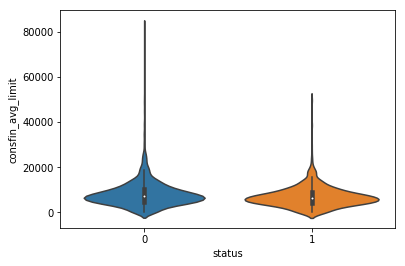

In [20]:
# 问题2：如何在一个for循环里面制作所有的提琴图
# 问题3：各种图形分析
sns_violinplot(train_num, "consfin_avg_limit")

确认缺失值的情况

In [21]:
train.isnull().sum().sort_values() / len(train) * 100

avg_price_last_12_month                        0.000000
trans_amount_3_month                           0.000000
take_amount_in_later_12_month_highest          0.000000
status                                         0.000000
pawns_auctions_trusts_consume_last_6_month     0.000000
pawns_auctions_trusts_consume_last_1_month     0.000000
max_cumulative_consume_later_1_month           0.000000
historical_trans_amount                        0.000000
is_high_user                                   0.000000
abs                                            0.000000
repayment_capability                           0.000000
avg_consume_less_12_valid_month                0.042070
low_volume_percent                             0.042070
reg_preference_for_trad                        0.042070
first_transaction_day                          0.042070
top_trans_count_last_1_month                   0.042070
rank_trad_1_month                              0.042070
trans_day_last_12_month                        0

不难发现除了 student_feature 缺失值在 63% 以外，其余的都不是非常多，这里使用平均值来补充
1. student_feature：使用0来填充
2. other：使用均值来补充

In [22]:
train_num.fillna({'student_feature': 0}, inplace=True)

In [23]:
train_num.fillna(train_num.mode(), inplace=True) # 众数
# train_num.fillna(train_num.mean(), inplace=True) # 均值
# train_num.fillna(train_num.median(), inplace=True) # 中位数

## 2.6 列数据合并

In [25]:
x_train = pd.concat([train_num, date_temp, train_object], axis=1)

In [28]:
x_train.shape

(4754, 92)